# Data analysis and figures creation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from src.figures_style import initialise_figures, get_color, get_categorical_palette
initialise_figures()

## Section 2: Theory and methods

### SIR Model with Delays

We use `sympy` to analyse delays in infectious-disease models, and to show how that can cause errors when estimating the effective reproduction number.

In [2]:
import sympy as sp

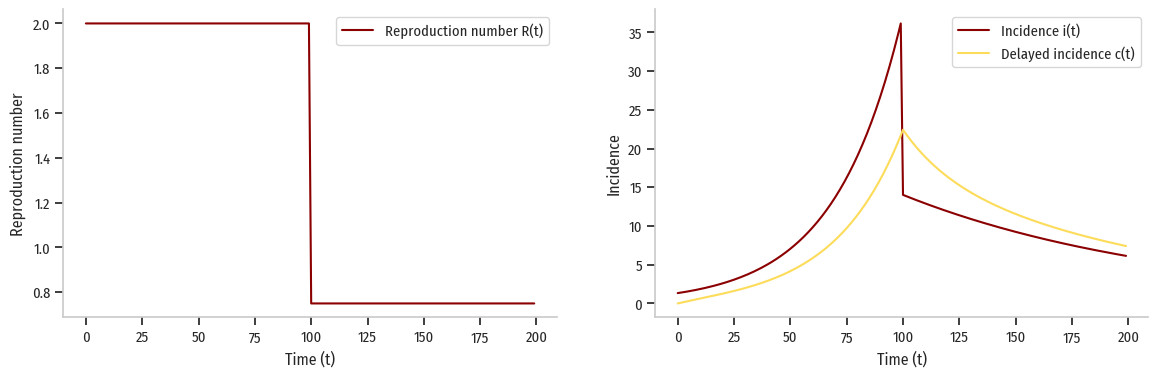

In [3]:
# Defining symbols
t, t_p, tau = sp.symbols('t t_p 𝜏', nonnegative=True)

# Defining constants
t_max = 200
gamma = 1/30
lamb_ = 1/20
i_0   = 20
t_c = t_max / 2

# Defining functions
r_t_sym = sp.Piecewise((2, t<t_c), (0.75, True))
p_tau_sym = lamb_ * sp.exp(-lamb_ * tau)

i_t_sym = i_0 * gamma * r_t_sym * sp.exp(gamma*(sp.integrate(r_t_sym.subs(t, t_p), (t_p, 0, t)) - t))
i_t_sym = i_t_sym.doit().simplify()

I_t_sym = (i_t_sym / (gamma * r_t_sym)).doit().simplify()

c_t_sym = sp.integrate(p_tau_sym * i_t_sym.subs(t, t-tau), (tau, 0, t))
c_t_sym = c_t_sym.doit().simplify()

# Defining lambdas
r_t_lamb = sp.lambdify([t], r_t_sym)
i_t_lamb = sp.lambdify([t], i_t_sym)
c_t_lamb = sp.lambdify([t], c_t_sym)

# Computing values
t = np.arange(t_max)
r_t_num = r_t_lamb(t)
i_t_num = np.array([i_t_lamb(x) for x in t])
c_t_num = np.array([c_t_lamb(x) for x in t])

# Drawing
_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(x=t, y=r_t_num, label='Reproduction number R(t)', ax=axs[0])
sns.lineplot(x=t, y=i_t_num, label='Incidence i(t)', color=get_color(0, 2), ax=axs[1])
sns.lineplot(x=t, y=c_t_num, label='Delayed incidence c(t)', color=get_color(1, 2), ax=axs[1])

axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Reproduction number')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Incidence')

for ax in axs:
    ax.grid(False)

plt.savefig('figures/incidence_real_vs_reported.png', bbox_inches='tight', pad_inches=0.)
plt.show()

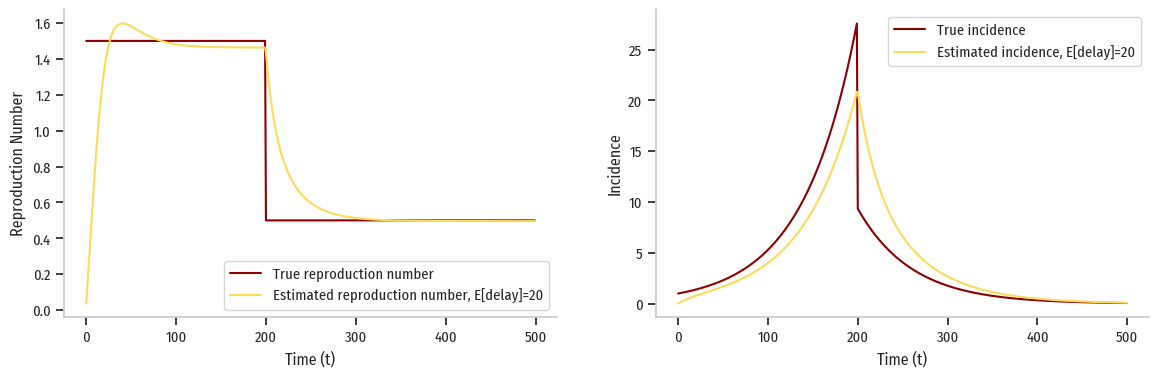

In [4]:
# Defining symbols
t, t_p, tau = sp.symbols('t t_p 𝜏', nonnegative=True)

# Defining constants
t_max = 500
gamma = 1/30

lamb1 = 1/10
lamb2 = 1/20

i_0   = 20
t_c = 200

# Defining functions
R_t_sym = sp.Piecewise((1.5, t<t_c), (0.5, True))
p_tau_sym1 = lamb1 * sp.exp(-lamb1 * tau)
p_tau_sym2 = lamb2 * sp.exp(-lamb2 * tau)

i_t_sym = i_0 * gamma * R_t_sym * sp.exp(gamma*(sp.integrate(R_t_sym.subs(t, t_p), (t_p, 0, t)) - t))
i_t_sym = i_t_sym.doit().simplify()

I_t_sym = (i_t_sym / (gamma * R_t_sym)).doit().simplify()

c_t_sym1 = sp.integrate(p_tau_sym1 * i_t_sym.subs(t, t-tau), (tau, 0, t))
c_t_sym1 = c_t_sym1.doit().simplify()
c_t_sym2 = sp.integrate(p_tau_sym2 * i_t_sym.subs(t, t-tau), (tau, 0, t))
c_t_sym2 = c_t_sym2.doit().simplify()

i_hat_sym1 = sp.integrate(c_t_sym1.subs(t, t_p), (t_p, t, t+1)).doit().simplify()
i_hat_sym2 = sp.integrate(c_t_sym2.subs(t, t_p), (t_p, t, t+1)).doit().simplify()

# Defining lambdas
R_t_lamb   = sp.lambdify([t], R_t_sym)
i_t_lamb   = sp.lambdify([t], i_t_sym)
I_t_lamb   = sp.lambdify([t], I_t_sym)

c_t_lamb1   = sp.lambdify([t], c_t_sym1)
i_hat_lamb1 = sp.lambdify([t], i_hat_sym1)

c_t_lamb2   = sp.lambdify([t], c_t_sym2)
i_hat_lamb2 = sp.lambdify([t], i_hat_sym2)

# Computing values
t = np.arange(t_max)
R_t_num = R_t_lamb(t)
i_t_num = np.array([i_t_lamb(x) for x in t])
I_t_num = np.array([I_t_lamb(x) for x in t])

c_t_num1 = np.array([c_t_lamb1(x) for x in t])
i_hat_num1 = np.array([i_hat_lamb1(x) for x in t])

c_t_num2 = np.array([c_t_lamb2(x) for x in t])
i_hat_num2 = np.array([i_hat_lamb2(x) for x in t])

I_hat_num1 = np.zeros_like(I_t_num)
I_hat_num1[0] = i_0
for i in range(1, len(I_hat_num1)):
    I_hat_num1[i] = I_hat_num1[i-1] * np.exp(-gamma) + i_hat_num1[i]
R_hat_num1 = i_hat_num1 / (gamma * I_hat_num1)

I_hat_num2 = np.zeros_like(I_t_num)
I_hat_num2[0] = i_0
for i in range(1, len(I_hat_num2)):
    I_hat_num2[i] = I_hat_num2[i-1] * np.exp(-gamma) + i_hat_num2[i]
R_hat_num2 = i_hat_num2 / (gamma * I_hat_num2)

# Drawing
_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(x=t, y=R_t_num, label='True reproduction number', color=get_color(0, 3), ax=axs[0])
sns.lineplot(x=t, y=R_hat_num2, label='Estimated reproduction number, E[delay]=20', color=get_color(2, 3), ax=axs[0])

sns.lineplot(x=t, y=i_t_num, label='True incidence', color=get_color(0, 3), ax=axs[1])
sns.lineplot(x=t, y=i_hat_num2, label='Estimated incidence, E[delay]=20', color=get_color(2, 3), ax=axs[1])

axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Reproduction Number')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Incidence')

for ax in axs:
    ax.grid(False)

plt.legend()
plt.savefig('figures/estimating_r_sir_delay.png', bbox_inches='tight', pad_inches=0.)
plt.show()

## Section 3: Data

We load our epidemiologic data from Statens Serum Institut and show it for the 2020 to 2021 timeframe.

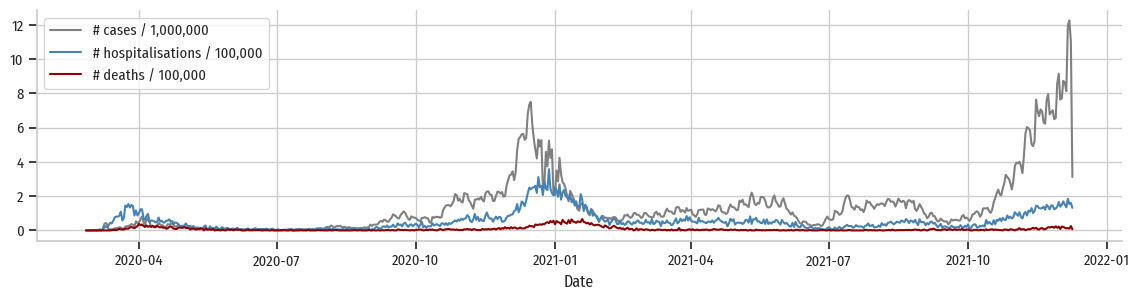

In [5]:
df = pd.read_csv('hope_data/epidata.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
REGIONS = df.groupby('region').size().index.tolist()

_, ax = plt.subplots(figsize=(14, 3))

df['cases_per_1000000'] = df['cases_per_100000'] / 10
df['Date'] = df['date']

df_dk = df[df['region'] == 'Danmark']

sns.lineplot(df_dk, x='Date', y='cases_per_1000000', label='# cases / 1,000,000', color='grey', ax=ax)
sns.lineplot(df_dk, x='Date', y='hospit_per_100000', label='# hospitalisations / 100,000', color='steelblue', ax=ax)
sns.lineplot(df_dk, x='Date', y='deaths_per_100000', label='# deaths / 100,000', color='darkred', ax=ax)

ax.set(ylabel='')

plt.savefig('figures/epidata.png', bbox_inches='tight', pad_inches=0.)
plt.show()

## Section 4: Data analysis

### NMF

We perform the NMF analysis of the survey data and show their evolution through time. We also compare them to our hand-crafted features.

In [6]:
DATA_PARQUET_PATH = 'hope_data/EWS_0326_klar.parquet'
df = pd.read_parquet(DATA_PARQUET_PATH)

df['Day'] = df['Timings_dateFinish'] # We use the date when the survey is submitted as a basis
totdays = df['Day'].nunique()

df['Week'] = df['Day'].dt.to_period('W').dt.start_time
df['Month'] = df['Day'].dt.to_period('M').dt.start_time
df['Year'] = df['Day'].dt.to_period('Y').dt.start_time

df['Q4a_all'] = df['Q4a_1'] + df['Q4a_2'] + df['Q4a_3'] + df['Q4a_4']
df['Q4b_all'] = df['Q4b_1'] + df['Q4b_2'] + df['Q4b_3'] + df['Q4b_4']

df_obs = df[(df['Day'] >= '2020-07-01') & (df['Day'] < '2020-10-01')]

df['at_risk_60'] = df['Q4a_all'] > np.quantile(df_obs['Q4a_all'], 0.60)
df['at_risk_70'] = df['Q4a_all'] > np.quantile(df_obs['Q4a_all'], 0.70)
df['at_risk_80'] = df['Q4a_all'] > np.quantile(df_obs['Q4a_all'], 0.80)
df['at_risk_90'] = df['Q4a_all'] > np.quantile(df_obs['Q4a_all'], 0.90)

del df_obs

df['ind_behave'] = df[[f'Q3_{i}' for i in range(1, 8)]].astype('double').mean(axis=1)
df['Q5_3_inv'] = df['Q5_3'].max() + 1 - df['Q5_3']
df['others_behave'] = (df['Q5_1'] + df['Q5_2'] + df['Q5_3_inv'] + df['Q6_3']).astype('double')/4
df['randoms_behave'] = (df['Q5_2'] + df['Q5_3_inv']).astype('double')/2
df['authorities_trust'] = (df['Q2_3'] + df['Q2_4'] + df['Q6_2'] + df['Q6_8'] + df['Q6_9']).astype('double')/5
df['life_degraded'] = (df['Q2_5'] + df['Q2_6'] + df['Q6_7']).astype('double')/3

In [7]:
from sklearn.decomposition import NMF

FEATURES = ['Q1_1', 'Q1_2'] + \
           [f'Q2_{i}' for i in range(1, 7)] + \
           [f'Q3_{i}' for i in range(1, 8)] + \
           [f'Q4a_{i}' for i in range(1, 5)] + \
           [f'Q5_{i}' for i in range(1, 6)] + \
           [f'Q6_{i}' for i in range(1, 10)] + \
           [f'Q7_{i}' for i in range(1, 6)]
    
df_red = df[FEATURES + ['Week', 'Day']].dropna(axis=0).copy()
for f in FEATURES:
    df_red[f] = df_red[f].rank(pct=True)

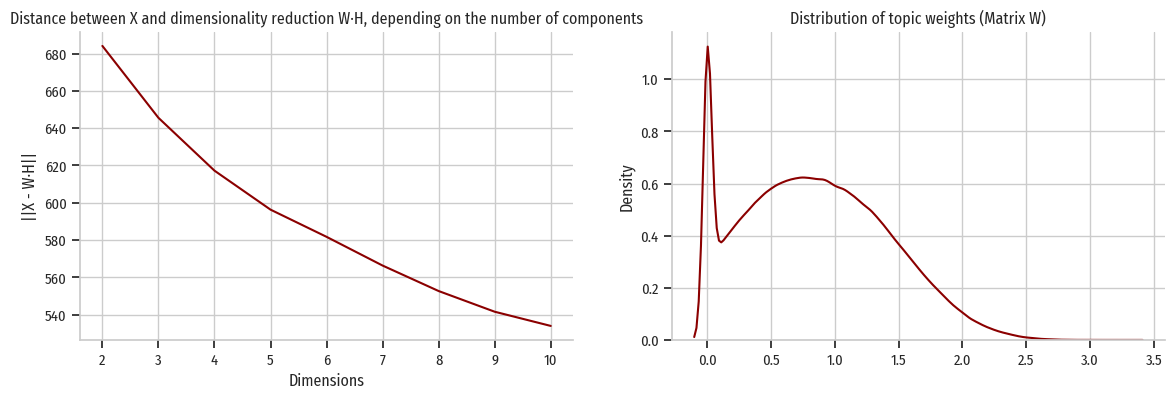

In [8]:
from numpy.linalg import norm

res = pd.DataFrame(columns=['Dimensions', '||X - W·H||'])
X = df_red.drop(['Week', 'Day'], axis=1).values

for i in range(2, 11):
    nmf = NMF(i, max_iter=1024, alpha_W=2e-3, alpha_H=1e-1)
    W = nmf.fit_transform(X)
    H = nmf.components_

    res.loc[len(res)] = (i, norm(X - W@H))
    
nmf = NMF(5, max_iter=1024, alpha_W=2e-3, alpha_H=1e-1)
W = nmf.fit_transform(X)
H = nmf.components_

_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(res, x='Dimensions', y='||X - W·H||', ax=axs[0]).set(title='Distance between X and dimensionality reduction W·H, depending on the number of components')
sns.kdeplot(W.flatten(), ax=axs[1]).set(title='Distribution of topic weights (Matrix W)')

plt.savefig('figures/nmf_parameters.png', bbox_inches='tight', pad_inches=0.)
plt.show()

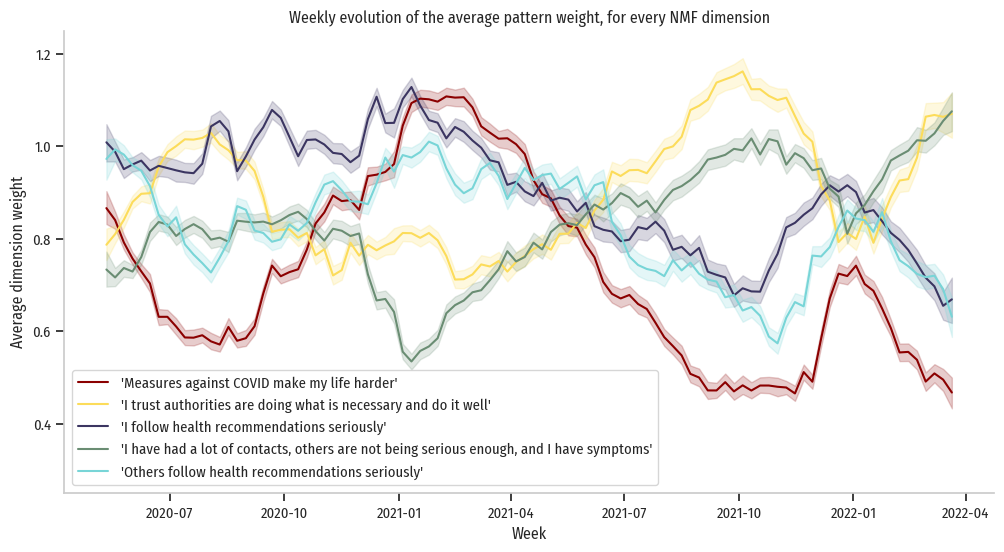

In [9]:
dimensions_labels = [
    "'Measures against COVID make my life harder'",
    "'I trust authorities are doing what is necessary and do it well'",
    "'I follow health recommendations seriously'",
    "'I have had a lot of contacts, others are not being serious enough, and I have symptoms'",
    "'Others follow health recommendations seriously'"
]

df_red[dimensions_labels] = W

_, ax = plt.subplots(figsize=(12, 6))

for f, feature in enumerate(dimensions_labels):
    sns.lineplot(
        data=df_red, x='Week', y=feature, estimator='mean', errorbar=('ci', 95), label=feature, color=get_categorical_palette(5)[f], ax=ax
    )

ax.set(title='Weekly evolution of the average pattern weight, for every NMF dimension',
       ylabel='Average dimension weight',
       ylim=(0.25, 1.25))

ax.grid(False)
    
plt.legend()
plt.savefig('figures/nmf_dimensions_weekly.png', bbox_inches='tight', pad_inches=0.)
plt.show()

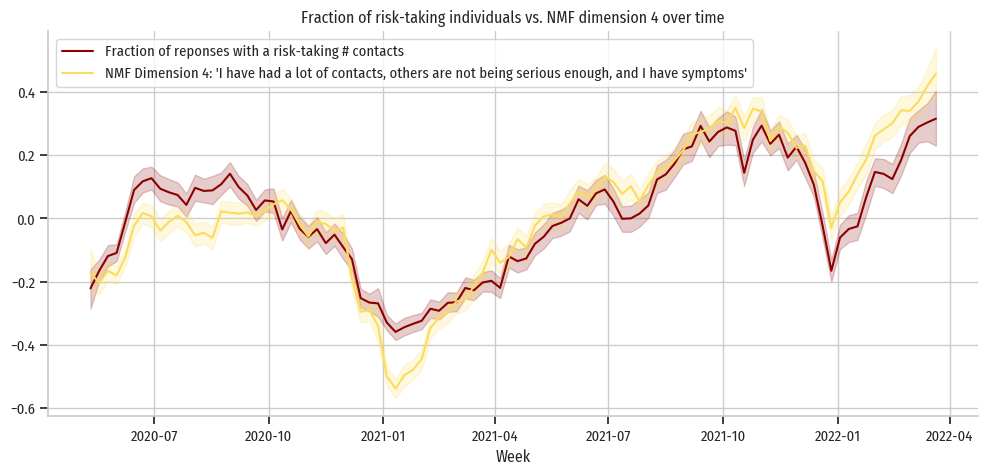

In [10]:
from sklearn.preprocessing import scale, minmax_scale, quantile_transform


df_red['Q4a_all'] = df.loc[df_red.index, 'Q4a_all']
df_red[['ind_behave', 'authorities_trust', 'life_degraded', 'others_behave', 'randoms_behave']] = scale(df.loc[df_red.index, ['ind_behave', 'authorities_trust', 'life_degraded', 'others_behave', 'randoms_behave']])
df_red[dimensions_labels] = scale(df_red[dimensions_labels])

df_obs = df_red[(df_red['Day'] >= '2020-07-01') & (df_red['Day'] < '2020-10-01')]

_, ax = plt.subplots(figsize=(12, 5))

df_red['Q4a_all_qtl'] = scale((df_red['Q4a_all'] > np.quantile(df_obs['Q4a_all'], 0.7)).astype('int'))
sns.lineplot(
    data=df_red, x='Week', y="Q4a_all_qtl", estimator='mean', errorbar=('ci', 95), label="Fraction of reponses with a risk-taking # contacts", color=get_color(0, 2), ax=ax
)

sns.lineplot(
    data=df_red, x='Week', y="'I have had a lot of contacts, others are not being serious enough, and I have symptoms'", estimator='mean', errorbar=('ci', 95), label="NMF Dimension 4: 'I have had a lot of contacts, others are not being serious enough, and I have symptoms'", color=get_color(1, 2), ax=ax
)

ax.set(title='Fraction of risk-taking individuals vs. NMF dimension 4 over time', ylabel='')
    
plt.legend()
plt.savefig('figures/comparison-nmf-handcrafted-contacts.png', bbox_inches='tight', pad_inches=0.)
plt.show()

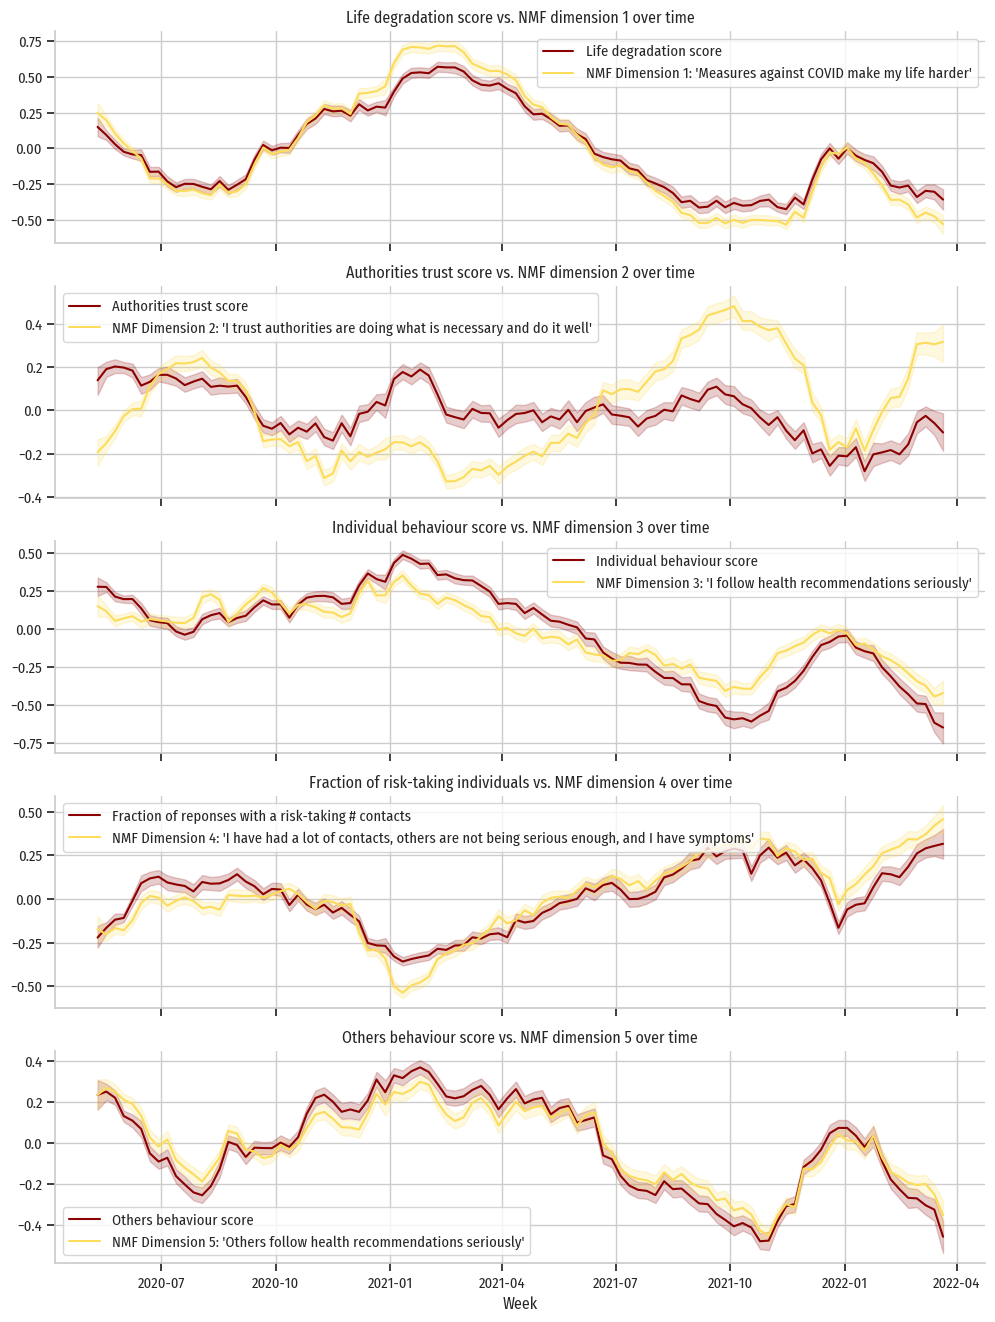

In [11]:
_, axs = plt.subplots(5, figsize=(12, 16), sharex=True)

# Life degradation

i = 0

sns.lineplot(
    data=df_red, x='Week', y="life_degraded", estimator='mean', errorbar=('ci', 95), label="Life degradation score", color=get_color(0, 2), ax=axs[i]
)

sns.lineplot(
    data=df_red, x='Week', y=dimensions_labels[i], estimator='mean', errorbar=('ci', 95), label=f"NMF Dimension {i+1}: {dimensions_labels[i]}", color=get_color(1, 2), ax=axs[i]
)

axs[i].set(title=f'Life degradation score vs. NMF dimension {i+1} over time', ylabel='')

# Authorities trust

i = 1

sns.lineplot(
    data=df_red, x='Week', y="authorities_trust", estimator='mean', errorbar=('ci', 95), label="Authorities trust score", color=get_color(0, 2), ax=axs[i]
)

sns.lineplot(
    data=df_red, x='Week', y=dimensions_labels[i], estimator='mean', errorbar=('ci', 95), label=f"NMF Dimension {i+1}: {dimensions_labels[i]}", color=get_color(1, 2), ax=axs[i]
)

axs[i].set(title=f'Authorities trust score vs. NMF dimension {i+1} over time', ylabel='')

# Individual behaviour

i = 2

sns.lineplot(
    data=df_red, x='Week', y="ind_behave", estimator='mean', errorbar=('ci', 95), label="Individual behaviour score", color=get_color(0, 2), ax=axs[i]
)

sns.lineplot(
    data=df_red, x='Week', y=dimensions_labels[i], estimator='mean', errorbar=('ci', 95), label=f"NMF Dimension {i+1}: {dimensions_labels[i]}", color=get_color(1, 2), ax=axs[i]
)

axs[i].set(title=f'Individual behaviour score vs. NMF dimension {i+1} over time', ylabel='')

# Contacts

df_red['Q4a_all_qtl'] = scale((df_red['Q4a_all'] > np.quantile(df_obs['Q4a_all'], 0.7)).astype('int'))
sns.lineplot(
    data=df_red, x='Week', y="Q4a_all_qtl", estimator='mean', errorbar=('ci', 95), label="Fraction of reponses with a risk-taking # contacts", color=get_color(0, 2), ax=axs[3]
)

sns.lineplot(
    data=df_red, x='Week', y="'I have had a lot of contacts, others are not being serious enough, and I have symptoms'", estimator='mean', errorbar=('ci', 95), label="NMF Dimension 4: 'I have had a lot of contacts, others are not being serious enough, and I have symptoms'", color=get_color(1, 2), ax=axs[3]
)

axs[3].set(title='Fraction of risk-taking individuals vs. NMF dimension 4 over time', ylabel='')

# Others behaviour

i = 4

sns.lineplot(
    data=df_red, x='Week', y="others_behave", estimator='mean', errorbar=('ci', 95), label="Others behaviour score", color=get_color(0, 2), ax=axs[i]
)

sns.lineplot(
    data=df_red, x='Week', y=dimensions_labels[i], estimator='mean', errorbar=('ci', 95), label=f"NMF Dimension {i+1}: {dimensions_labels[i]}", color=get_color(1, 2), ax=axs[i]
)

axs[i].set(title=f'Others behaviour score vs. NMF dimension {i+1} over time', ylabel='')
    
plt.legend()
plt.savefig('figures/comparison-nmf-handcrafted-all.png', bbox_inches='tight', pad_inches=0.)
plt.show()

### Exploring age

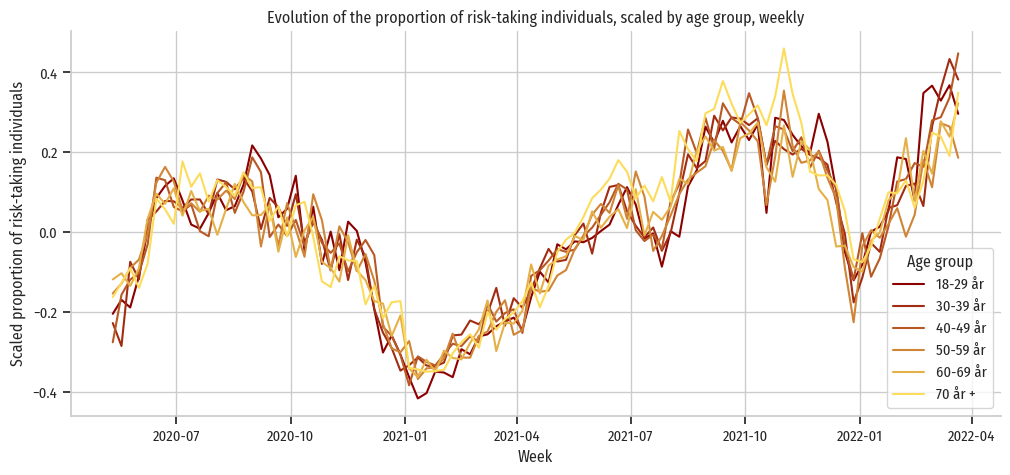

In [12]:
ALDER_ORDER = ['18-29 år', '30-39 år', '40-49 år', '50-59 år', '60-69 år', '70 år +']
CONTACTS_THR = np.quantile(df[(df['Day'] >= '2020-07-01') & (df['Day'] < '2020-10-01')]['Q4a_all'], 0.7)

df['at_risk_70'] = df['Q4a_all'] > CONTACTS_THR

_, ax = plt.subplots(figsize=(12, 5))

for cat in ALDER_ORDER:
    df.loc[df['aldercat'] == cat, 'at_risk_70_scaled'] = scale(df.loc[df['aldercat'] == cat, 'at_risk_70'])

df['Age group'] = df['aldercat']
    
sns.lineplot(
    data=df, x='Week', y='at_risk_70_scaled', estimator='mean', hue='Age group', hue_order=ALDER_ORDER, errorbar=None, ax=ax
).set(ylabel='Scaled proportion of risk-taking individuals', title='Evolution of the proportion of risk-taking individuals, scaled by age group, weekly')

plt.savefig('figures/comparison-contacts-agegroups.png', bbox_inches='tight', pad_inches=0.)
plt.show()

### Exploring sex

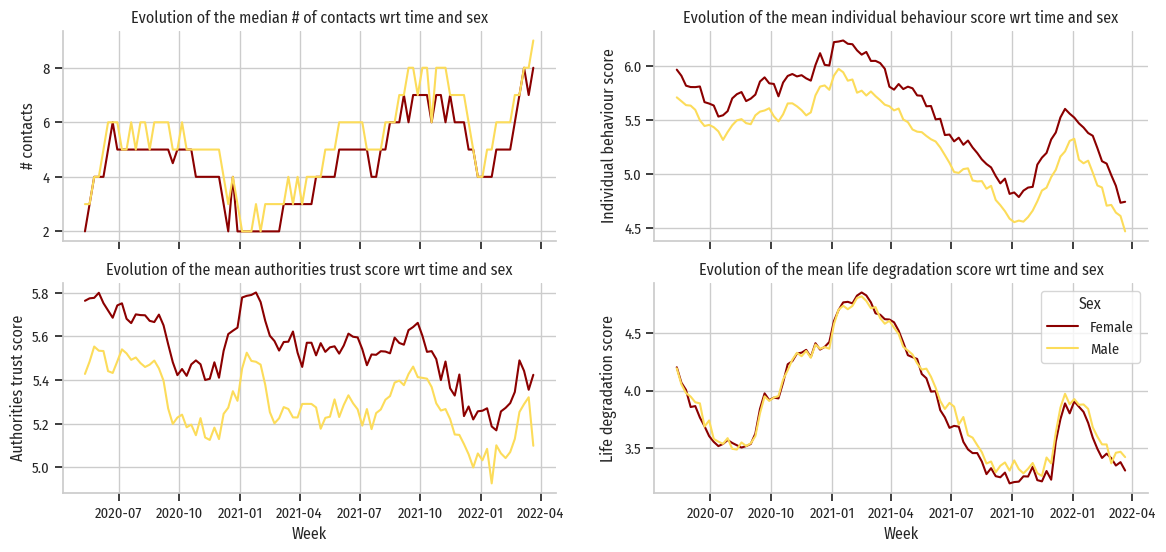

In [13]:
_, axs = plt.subplots(2, 2, figsize=(14, 6), sharex=True)

df['Sex'] = df['koen'].map({
    'Mand': 'Male',
    'Kvinde': 'Female'
})

sns.lineplot(
    data=df, x='Week', y='Q4a_all', hue='Sex', estimator='median', errorbar=None, palette=get_categorical_palette(2), ax=axs[0][0]
).set(title='Evolution of the median # of contacts wrt time and sex', ylabel='# contacts')

sns.lineplot(
    data=df, x='Week', y='ind_behave', hue='Sex', estimator='mean', errorbar=None, palette=get_categorical_palette(2), ax=axs[0][1]
).set(title='Evolution of the mean individual behaviour score wrt time and sex', ylabel='Individual behaviour score')

sns.lineplot(
    data=df, x='Week', y='authorities_trust', hue='Sex', estimator='mean', errorbar=None, palette=get_categorical_palette(2), ax=axs[1][0]
).set(title='Evolution of the mean authorities trust score wrt time and sex', ylabel='Authorities trust score')

sns.lineplot(
    data=df, x='Week', y='life_degraded', hue='Sex', estimator='mean', errorbar=None, palette=get_categorical_palette(2), ax=axs[1][1]
).set(title='Evolution of the mean life degradation score wrt time and sex', ylabel='Life degradation score')

axs[0][0].get_legend().remove()
axs[0][1].get_legend().remove()
axs[1][0].get_legend().remove()

plt.savefig('figures/comparison-sex.png', bbox_inches='tight', pad_inches=0.)
plt.show()

### Exploring occupation

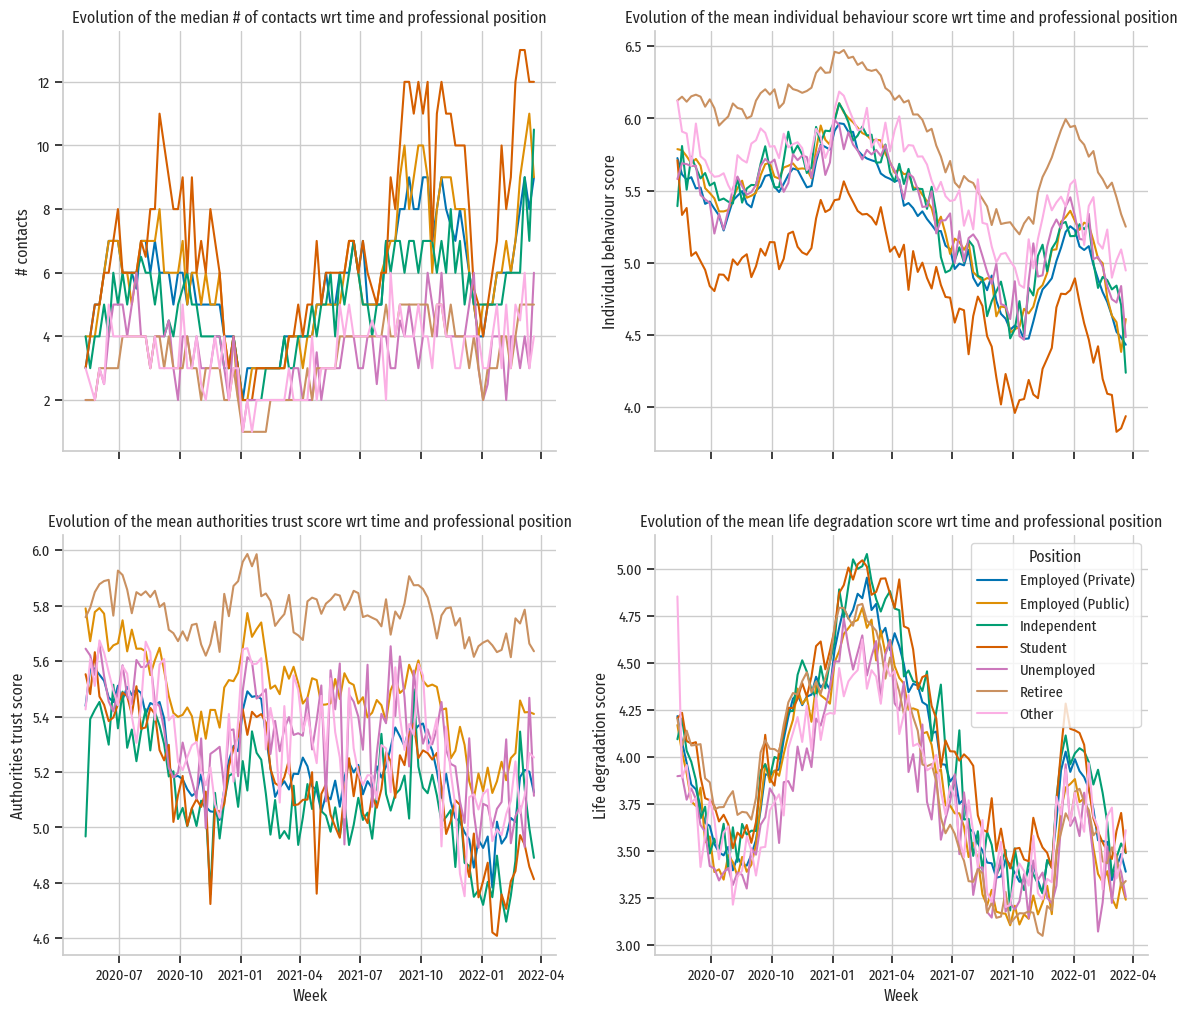

In [14]:
df['Position'] = df['Q14'].map({
    'Lønmodtager i en privat virksomhed': 'Employed (Private)',
    'Lønmodtager i det offentlige (stat, kommune eller region)': 'Employed (Public)',
    'Selvstændig': 'Independent',
    'Under uddannelse': 'Student',
    'Arbejdsløs': 'Unemployed',
    'Pensionist eller efterlønsmodtager': 'Retiree',
    'Andet': 'Other'
})

POSITION_ORDER = [
    'Employed (Private)',
    'Employed (Public)',
    'Independent',
    'Student',
    'Unemployed',
    'Retiree',
    'Other'  
]

_, axs = plt.subplots(2, 2, figsize=(14, 12), sharex=True)

sns.lineplot(
    data=df, x='Week', y='Q4a_all', hue='Position',hue_order=POSITION_ORDER, estimator='median', errorbar=None, palette='colorblind', ax=axs[0][0]
).set(title='Evolution of the median # of contacts wrt time and professional position', ylabel='# contacts')

sns.lineplot(
    data=df, x='Week', y='ind_behave', hue='Position',hue_order=POSITION_ORDER, estimator='mean', errorbar=None, palette='colorblind', ax=axs[0][1]
).set(title='Evolution of the mean individual behaviour score wrt time and professional position', ylabel='Individual behaviour score')

sns.lineplot(
    data=df, x='Week', y='authorities_trust', hue='Position',hue_order=POSITION_ORDER, estimator='mean', errorbar=None, palette='colorblind', ax=axs[1][0]
).set(title='Evolution of the mean authorities trust score wrt time and professional position', ylabel='Authorities trust score')

sns.lineplot(
    data=df, x='Week', y='life_degraded', hue='Position',hue_order=POSITION_ORDER, estimator='mean', errorbar=None, palette='colorblind', ax=axs[1][1]
).set(title='Evolution of the mean life degradation score wrt time and professional position', ylabel='Life degradation score')

axs[0][0].get_legend().remove()
axs[0][1].get_legend().remove()
axs[1][0].get_legend().remove()

plt.savefig('figures/comparison-position.png', bbox_inches='tight', pad_inches=0.)
plt.show()

### Exploring politics

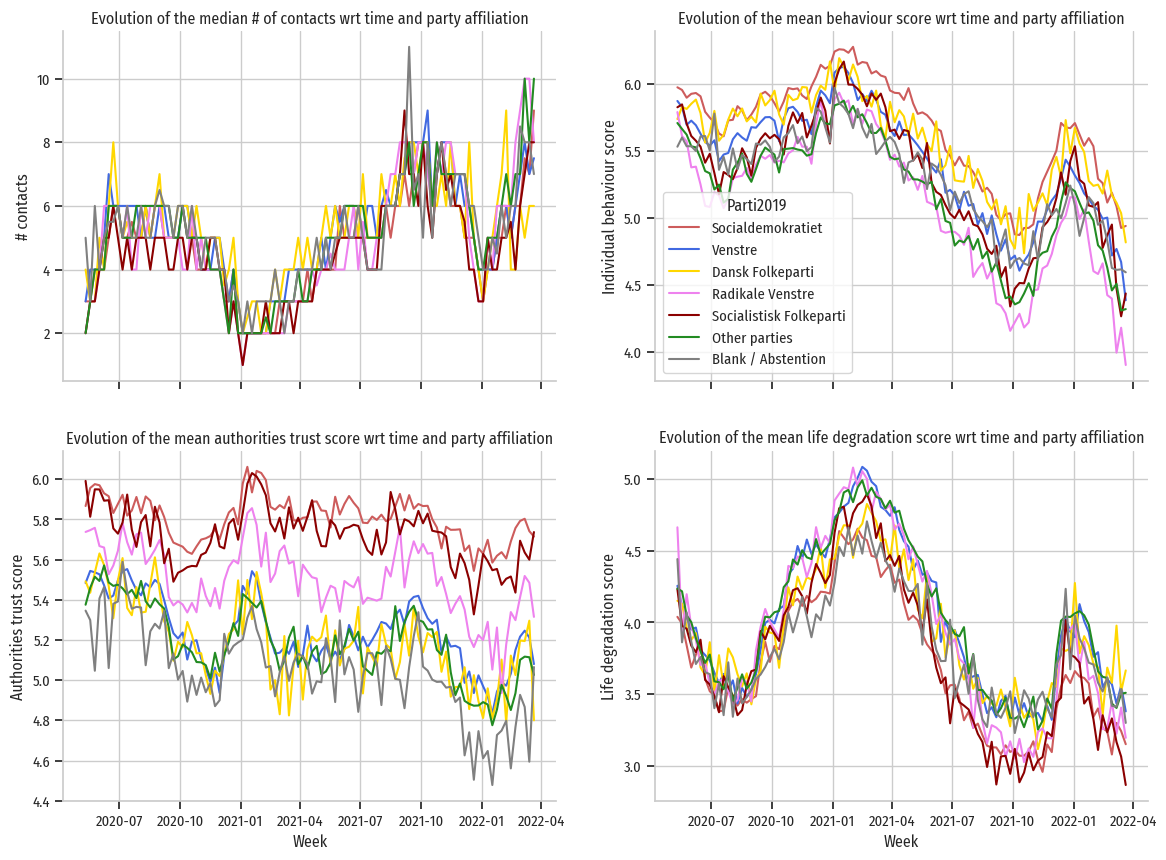

In [15]:
df['Parti2019'] = df['Q15'].map({
    'A: Socialdemokratiet': 'Socialdemokratiet',
    'V: Venstre': 'Venstre',
    'O: Dansk Folkeparti': 'Dansk Folkeparti',
    'B: Radikale': 'Radikale Venstre',
    'F: Socialistisk Folkeparti': 'Socialistisk Folkeparti',
    'C: Konservative': 'Other parties',
    'D: Nye Borgerlige': 'Other parties',
    'E: Klaus Riskjær Pedersen': 'Other parties',
    'I: Liberal Alliance': 'Other parties',
    'K: Kristendemokraterne': 'Other parties',
    'P: Stram Kurs': 'Other parties',
    'Ø: Enhedslisten': 'Other parties',
    'Å: Alternativet': 'Other parties',
    'Andre partier/kandidat uden for partierne': 'Other parties',
    'Stemte blankt': 'Blank / Abstention',
    'Stemte ikke': 'Blank / Abstention'
}).astype('category')

PARTI_COLOURS = {
    'Socialdemokratiet': 'indianred',
    'Venstre': 'royalblue',
    'Dansk Folkeparti': 'gold',
    'Radikale Venstre': 'violet',
    'Socialistisk Folkeparti': 'darkred',
    'Other parties': 'forestgreen',
    'Blank / Abstention': 'grey'
}

GROUNDTRUTH_2019 = {
    'Socialdemokratiet': 0.2191,
    'Venstre': 0.1979,
    'Dansk Folkeparti': 0.0739,
    'Radikale Venstre': 0.0730,
    'Socialistisk Folkeparti': 0.0652,
    'Other parties': 0.2079,
    'Blank / Abstention': 0.1630
}

_, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

sns.lineplot(
    data=df, x='Week', y='Q4a_all', hue='Parti2019', hue_order=PARTI_COLOURS.keys(), palette=PARTI_COLOURS, estimator='median', errorbar=None, ax=axs[0][0]
).set(title='Evolution of the median # of contacts wrt time and party affiliation', ylabel='# contacts')

sns.lineplot(
    data=df, x='Week', y='ind_behave', hue='Parti2019', hue_order=PARTI_COLOURS.keys(), palette=PARTI_COLOURS, estimator='mean', errorbar=None, ax=axs[0][1]
).set(title='Evolution of the mean behaviour score wrt time and party affiliation', ylabel='Individual behaviour score')

sns.lineplot(
    data=df, x='Week', y='authorities_trust', hue='Parti2019', hue_order=PARTI_COLOURS.keys(), palette=PARTI_COLOURS, estimator='mean', errorbar=None, ax=axs[1][0]
).set(title='Evolution of the mean authorities trust score wrt time and party affiliation', ylabel='Authorities trust score')

sns.lineplot(
    data=df, x='Week', y='life_degraded', hue='Parti2019', hue_order=PARTI_COLOURS.keys(), palette=PARTI_COLOURS, estimator='mean', errorbar=None, ax=axs[1][1]
).set(title='Evolution of the mean life degradation score wrt time and party affiliation', ylabel='Life degradation score')

axs[0][0].get_legend().remove()
axs[1][1].get_legend().remove()
axs[1][0].get_legend().remove()

plt.savefig('figures/comparison-politics.png', bbox_inches='tight', pad_inches=0.)

plt.show()